In [1]:
# import agent-torch

import os
import sys
module_path = os.path.abspath(os.path.join('../../../agent_torch'))
if module_path not in sys.path:
    sys.path.append(module_path)

from AgentTorch import Runner, Registry
from AgentTorch.substep import SubstepObservation, SubstepAction, SubstepTransition
from AgentTorch.helpers import get_by_path, read_config, read_from_file, grid_network

In [2]:
# import all external libraries that we need.

import math
import torch
import re
import random
import argparse
import numpy as np
import torch.nn as nn
import networkx as nx
import osmnx as ox
from tqdm import trange

In [3]:
# define the helper functions we need.

def get_var(state, var):
  """
    Retrieves a value from the current state of the model.
  """
  return get_by_path(state, re.split('/', var))

# Predator-Prey Model

> The complete code for this model can be found [here](../). The architecture of
> the AgentTorch framework, which explains some key concepts, can be found
> [here](https://github.com/AgentTorch/AgentTorch/pull/9/files?short_path=140eef3#diff-140eef3ba41bdcf401d507408084181f2c0ac627532b61e0f7906ea7cc926782).

This guide walks you through creating a custom predator-prey model using the
AgentTorch framework. This model will simulate an ecosystem consisting of
predators, prey and grass: predators eat prey, and prey eat grass.

The model's parameters, rules and configuration are passed to AgentTorch, which
iteratively simulates the model, allowing you to optimize its learnable
parameters, while also modelling the simulation in real time. AgentTorch's
Python API is based on PyTorch, which enhances its performance on GPUs.

The following sections detail:

- an overview of the model's rules and parameters.
- the properties of all entities stored in the model's state.
- the substeps that observe, simulate and modify the state for each agent.
- the code required to run the simulation using `agent-torch`.
- plotting the state's trajectory using `matplotlib`.

## Model Overview

The following are configurable parameters of the model:

- a $n \times m$ grid, with $p$ predators and $q$ prey to start with.
- grass can grown on any of the $n \cdot m$ squares in the grid.

The rules followed by the simulated interactions are configured as follows:

- predators can eat only prey, and prey can eat only grass.
- grass grows back once eaten after a certain number of steps.
- upon consuming food, the energy of the consumer increases.
- movement happens randomly, to any neighbouring square in the grid.
- each move reduces the energy of the entity by a fixed amount.

These parameters and rules, along with the properties of the entities (detailed
below) in the simulation are defined in a configuration file, and passed on to
the model.

## State: Environment, Agents, and Objects

The model's state consists of a list of properties of the simulated environment,
and the agents and objects situated in that simulation. For this model, the:

### Environment

The environment will have only one property: the size of the two-dimensional
grid in which the predators and prey wander, defined like so:

```yaml
environment:
  bounds: (max_x, max_y) # tuple of integers
```

### Agents

This model has two agents: predator, and prey.

#### Predator

The predator agent is defined like so:

```yaml
predator:
  coordinates: (x, y) # tuple of integers
  energy: float
  stride_work: float
```

The `coordinates` property depicts the current position of the predator in the
two-dimensional grid. It is initialized from a CSV file that contains a list of
randomly generated coordinates for all 40 predators.

The `energy` property stores the current amount of energy possessed by the
predator. Initially, this property is set to a random number between 30 and 100.

The `stride_work` property is a static, but learnable property that stores the
amount of energy to deduct from a predator for one step in any direction on the
grid.

#### Prey

The prey agent is identical to the predator agent, and has one additional
property: `nutritional_value`.

```yaml
prey:
  coordinates: (x, y) # tuple of integers
  energy: float
  stride_work: float
  nutritional_value: float
```

The `nutritional_value` property is a static but learnable property that stores
the amount of energy gained by a predator when it consumes a single prey entity.

### Objects

This model has only one agent: grass.

#### Grass

The grass entity is defined as follows:

```yaml
grass:
  coordinates: (x, y)
  growth_stage: 0|1
  growth_countdown: float
  regrowth_time: float
  nutritional_value: float
```

The `coordinates` property depicts the current position of the predator in the
two-dimensional grid. It is initialized from a CSV file that contains a list of
all 1600 coordinates.

The `growth_stage` property stores the current growth stage of the grass: 0
means it is growing, and 1 means it is fully grown.

The `growth_countdown` property stores the number of steps after which the grass
becomes fully grown. The `regrowth_time` property is static and learnable, and
stores the max value of the countdown property.

The `nutritional_value` property is a static but learnable property that stores
the amount of energy gained by a predator when it consumes a single prey entity.

## Network

The model makes use of the adjacency matrix of a two-dimensional grid filled
with predator and prey to simulate the movement of those entities.

```yaml
network:
  agent_agent:
    grid: [predator, prey]
```

## Substeps

Each substep is a `torch.nn.ModuleDict` that takes an input state, and produces
an updated state as output. A substep consists of three phases:

1. Observation (retrieving relevant information from the state)
2. Policy/Action (deciding on the course of action as per the observations)
3. Transition (randomizing and updating the state according to the action)

This model consists of four substeps: `move`, `eat_grass`, `hunt_prey`, and
`grow_grass`.

In [4]:
# define all the helper functions we need.

def get_neighbors(pos, adj_grid, bounds):
  """
    Returns a list of neighbours for each position passed in the given
    `pos` tensor, using the adjacency matrix passed in `adj_grid`.
  """
  x, y = pos
  max_x, max_y = bounds

  # calculate the node number from the x, y coordinate.
  # each item (i, j) in the adjacency matrix, if 1 depicts
  # that i is connected to j and vice versa.
  node = (max_y * x) + y
  conn = adj_grid[node]

  neighbors = []
  for idx, cell in enumerate(conn):
    # if connected, calculate the (x, y) coords of the other
    # node and add it to the list of neighbors.
    if cell == 1:
      c = (int) (idx % max_y)
      r = math.floor((idx - c) / max_y)

      neighbors.append(
        [torch.tensor(r), torch.tensor(c)]
      )

  return torch.tensor(neighbors)

# define a function to retrieve the input required
def get_find_neighbors_input(state, input_variables):
    bounds = get_var(state, input_variables['bounds'])
    adj_grid = get_var(state, input_variables['adj_grid'])
    positions = get_var(state, input_variables['positions'])
    
    return bounds, adj_grid, positions

def get_decide_movement_input(state, input_variables):
    positions = get_var(state, input_variables['positions'])
    energy = get_var(state, input_variables['energy'])
    
    return positions, energy

def get_update_positions_input(state, input_variables):
    prey_energy = get_var(state, input_variables['prey_energy'])
    pred_energy = get_var(state, input_variables['pred_energy'])
    prey_work = get_var(state, input_variables['prey_work'])
    pred_work = get_var(state, input_variables['pred_work'])

    return prey_energy, pred_energy, prey_work, pred_work

def get_find_eatable_grass_input(state, input_variables):
    bounds = get_var(state, input_variables['bounds'])
    positions = get_var(state, input_variables['positions'])
    grass_growth = get_var(state, input_variables['grass_growth'])

    return bounds, positions, grass_growth

def get_eat_grass_input(state, input_variables):
    bounds = get_var(state, input_variables['bounds'])
    prey_pos = get_var(state, input_variables['prey_pos'])
    energy = get_var(state, input_variables['energy'])
    nutrition = get_var(state, input_variables['nutrition'])
    grass_growth = get_var(state, input_variables['grass_growth'])
    growth_countdown = get_var(state, input_variables['growth_countdown'])
    regrowth_time = get_var(state, input_variables['regrowth_time'])

    return bounds, prey_pos, energy, nutrition, grass_growth, growth_countdown, regrowth_time

def get_find_targets_input(state, input_variables):
    prey_pos = get_var(state, input_variables['prey_pos'])
    pred_pos = get_var(state, input_variables['pred_pos'])

    return prey_pos, pred_pos

def get_hunt_prey_input(state, input_variables):
    prey_pos = get_var(state, input_variables['prey_pos'])
    prey_energy = get_var(state, input_variables['prey_energy'])
    pred_pos = get_var(state, input_variables['pred_pos'])
    pred_energy = get_var(state, input_variables['pred_energy'])
    nutrition = get_var(state, input_variables['nutritional_value'])

    return prey_pos, prey_energy, pred_pos, pred_energy, nutrition

def get_grow_grass_input(state, input_variables):
    grass_growth = get_var(state, input_variables['grass_growth'])
    growth_countdown = get_var(state, input_variables['growth_countdown'])

    return grass_growth, growth_countdown

### Move

First, we **observe** the state, and find a list of neighboring positions for
each of the predators/prey currently alive.

In [5]:
@Registry.register_substep("find_neighbors", "observation")
class FindNeighbors(SubstepObservation):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, state):
    bounds, adj_grid, positions = get_find_neighbors_input(state, self.input_variables)

    # for each agent (prey/predator), find the adjacent cells and pass
    # them on to the policy class.
    possible_neighbors = []
    for pos in positions:
      possible_neighbors.append(
        get_neighbors(pos, adj_grid, bounds)
      )

    return { self.output_variables[0]: possible_neighbors }

Then, we decide the course of **action**: to move each entity to a random
neighboring position, only if they have the energy to do so.

In [6]:
@Registry.register_substep("decide_movement", "policy")
class DecideMovement(SubstepAction):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, state, observations):
    positions, energy = get_decide_movement_input(state, self.input_variables)
    possible_neighbors = observations['possible_neighbors']

    # randomly choose the next position of the agent. if the agent
    # has non-positive energy, don't let it move.
    next_positions = []
    for idx, pos in enumerate(positions):
      next_positions.append(
        random.choice(possible_neighbors[idx]) if energy[idx] > 0 else pos
      )

    return { self.output_variables[0]: torch.stack(next_positions, dim=0) }

Lastly, we **update** the state, with the new positions of the entities, and
reduce the energy of each entity by the value of the `stride_work` learnable
parameter.

In [7]:
@Registry.register_substep("update_positions", "transition")
class UpdatePositions(SubstepTransition):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, state, action):
    prey_energy, pred_energy, prey_work, pred_work = get_update_positions_input(state, self.input_variables)

    # reduce the energy of the agent by the work required by them
    # to take one step.
    prey_energy = prey_energy + torch.full(prey_energy.shape, -1 * (prey_work.item()))
    pred_energy = pred_energy + torch.full(pred_energy.shape, -1 * (pred_work.item()))
    
    return {
      self.output_variables[0]: action['prey']['next_positions'],
      self.output_variables[1]: prey_energy,
      self.output_variables[2]: action['predator']['next_positions'],
      self.output_variables[3]: pred_energy
    }

### Eat

First, **decide** which grass is fit to be consumed by the prey.

In [8]:
@Registry.register_substep("find_eatable_grass", "policy")
class FindEatableGrass(SubstepAction):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, state, observations):
    bounds, positions, grass_growth = get_find_eatable_grass_input(state, self.input_variables)

    # if the grass is fully grown, i.e., its growth_stage is equal to
    # 1, then it can be consumed by prey.
    eatable_grass_positions = []
    max_x, max_y = bounds
    for pos in positions:
      x, y = pos
      node = (max_y * x) + y
      if grass_growth[node] == 1:
        eatable_grass_positions.append(pos)

    # pass on the consumable grass positions to the transition class.
    return { self.output_variables[0]: eatable_grass_positions }

Then, simulate the consumption of the grass, and **update** the growth stage,
growth countdown, and energies of the grass and prey respectively.

In [9]:
@Registry.register_substep("eat_grass", "transition")
class EatGrass(SubstepTransition):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, state, action):
    bounds, prey_pos, energy, nutrition, grass_growth, growth_countdown, regrowth_time = get_eat_grass_input(state, self.input_variables)

    # if no grass can be eaten, skip modifying the state.
    if len(action['prey']['eatable_grass_positions']) < 1:
      return {}

    eatable_grass_positions = torch.stack(action['prey']['eatable_grass_positions'], dim=0)
    max_x, max_y = bounds
    energy_mask = None
    grass_mask, countdown_mask = torch.zeros(*grass_growth.shape), torch.zeros(*growth_countdown.shape)

    # for each consumable grass, figure out if any prey agent is at
    # that position. if yes, then mark that position in the mask as
    # true. also, for all the grass that will be consumed, reset the
    # growth stage.
    for pos in eatable_grass_positions:
      x, y = pos
      node = (max_y * x) + y

      # TODO: make sure dead prey cannot eat
      e_m = (pos == prey_pos).all(dim=1).view(-1, 1)
      if energy_mask is None:
        energy_mask = e_m
      else:
        energy_mask = e_m + energy_mask

      grass_mask[node] = -1
      countdown_mask[node] = regrowth_time - growth_countdown[node]

    # energy + nutrition adds the `nutrition` tensor to all elements in
    # the energy tensor. the (~energy_mask) ensures that the change is
    # undone for those prey that did not consume grass.
    energy = energy_mask*(energy + nutrition) + (~energy_mask)*energy

    # these masks use simple addition to make changes to the original
    # values of the tensors.
    grass_growth = grass_growth + grass_mask
    growth_countdown = growth_countdown + countdown_mask

    return {
      self.output_variables[0]: energy,
      self.output_variables[1]: grass_growth,
      self.output_variables[2]: growth_countdown
    }

### Hunt

First, **decide** which prey are to be eaten.

In [10]:
@Registry.register_substep("find_targets", "policy")
class FindTargets(SubstepAction):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, state, observations):
    prey_pos, pred_pos = get_find_targets_input(state, self.input_variables)

    # if there are any prey at the same position as a predator,
    # add them to the list of targets to kill.
    target_positions = []
    for pos in pred_pos:
      if (pos == prey_pos).all(-1).any(-1) == True:
        target_positions.append(pos)

    # pass that list of targets to the transition class.
    return { self.output_variables[0]: target_positions }

Then, **update** the energies of both the prey and the predator.

In [11]:
@Registry.register_substep("hunt_prey", "transition")
class HuntPrey(SubstepTransition):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, state, action):
    prey_pos, prey_energy, pred_pos, pred_energy, nutrition = get_hunt_prey_input(state, self.input_variables)

    # if there are no targets, skip the state modifications.
    if len(action['predator']['target_positions']) < 1:
      return {}

    target_positions = torch.stack(action['predator']['target_positions'], dim=0)

    # these are masks similars to the ones in `substeps/eat.py`.
    prey_energy_mask = None
    pred_energy_mask = None
    for pos in target_positions:
      pye_m = (pos == prey_pos).all(dim=1).view(-1, 1)
      if prey_energy_mask is None:
        prey_energy_mask = pye_m
      else:
        prey_energy_mask = prey_energy_mask + pye_m

      pde_m = (pos == pred_pos).all(dim=1).view(-1, 1)
      if pred_energy_mask is None:
        pred_energy_mask = pde_m
      else:
        pred_energy_mask = pred_energy_mask + pde_m

    # any prey that is marked for death should be given zero energy.
    prey_energy = prey_energy_mask*0 + (~prey_energy_mask)*prey_energy
    # any predator that has hunted should be given additional energy.
    pred_energy = pred_energy_mask*(pred_energy + nutrition) + (~pred_energy_mask)*pred_energy

    return {
      self.output_variables[0]: prey_energy,
      self.output_variables[1]: pred_energy
    }

### Grow

In this substep, we simply **update** the growth countdown of every grass
object, and if the countdown has elapsed, we update the growth stage to `1`.

In [12]:
@Registry.register_substep("grow_grass", "transition")
class GrowGrass(SubstepTransition):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def forward(self, state, action):
    grass_growth, growth_countdown = get_grow_grass_input(state, self.input_variables)

    # reduce all countdowns by 1 unit of time.
    growth_countdown_mask = torch.full(growth_countdown.shape, -1)
    growth_countdown = growth_countdown + growth_countdown_mask

    # if the countdown has reached zero, set the growth stage to 1,
    # otherwise, keep it zero.
    grass_growth_mask = (growth_countdown <= 0).all(dim=1)
    grass_growth = grass_growth_mask*(1) + (~grass_growth_mask)*(0)

    return {
      self.output_variables[0]: grass_growth.view(-1, 1),
      self.output_variables[1]: growth_countdown
    }

## Execution: Configuration, Registry, and Runner

### Configuration

There are several parts to the configuration, written in a file traditionally
called `config.yaml`. The following is a brief overview of all the major
sections in the configuration file.

```yaml
# config.yaml
# configuration for the predator-prey model.

metadata:
  # device type, episode count, data files, etc.

state:
  environment:
    # variables/properties of the simulated enviroment.

  agents:
    # a list of agents in the simulation, and their properties.
    # each property must be initialized by specifying a value
    # or a generator function, and have a fixed tensor shape.

  objects:
    # a list of objects, similar to the agents list.

  network:
    # a list of interaction models for the simulation.
    # could be a grid, or a directed graph, etc.

substeps:
  # a list of substeps
  # each substep has a list of agents to run that substep for
  # as well as the function, input and output variables for each
  # part of that substep (observation, policy and transition)
```

The following is an example of defining a property in the configuration.

```yaml
bounds:
  name: 'Bounds'
  learnable: false
  shape: 2
  dtype: 'int'
  value:
    - ${simulation_metadata.max_x} # you can refer to other parts of the config using
    - ${simulation_metadata.max_y} # the template syntax, i.e., ${path.to.config.value}
  initialization_function: null
```

Notice that to define one single property, we mentioned:

- the name of the property, here, `'bounds'`.
- whether or not the property is learnable, in this case, `false`.
- the shape of the tensor that stores the values, in this case, it is a
  one-dimensional array of two elements: `(max_x, max_y)`.
- the value of the property, either by directly providing the value or by
  providing a function that returns the value.

The full configuration for the predator-prey model can be found
[here](../config.yaml).

In [13]:
# define helper functions used in the configuration

@Registry.register_helper('map', 'network')
def map_network(params):
  coordinates = (40.78264403323726, -73.96559413265355) # central park
  distance = 550

  graph = ox.graph_from_point(coordinates, dist=distance, simplify=True, network_type="walk")
  adjacency_matrix = nx.adjacency_matrix(graph).todense()

  return graph, torch.tensor(adjacency_matrix)

@Registry.register_helper('random_float', 'initialization')
def random_float(shape, params):
  """
    Generates a `Tensor` of the given shape, with random floating point
    numbers in between and including the lower and upper limit.
  """

  max = params['upper_limit'] + 1 # include max itself.
  min = params['lower_limit']

  # torch.rand returns a tensor of the given shape, filled with
  # floating point numbers in the range (0, 1]. multiplying the
  # tensor by max - min and adding the min value ensure it's
  # within the given range.
  tens = (max - min) * torch.rand(shape) + min

  return tens

@Registry.register_helper('random_int', 'initialization')
def random_int(shape, params):
  """
    Generates a `Tensor` of the given shape, with random integers in
    between and including the lower and upper limit.
  """

  max = math.floor(params['upper_limit'] + 1) # include max itself.
  min = math.floor(params['lower_limit'])

  # torch.randint returns the tensor we need.
  tens = torch.randint(min, max, shape)

  return tens

### Registry and Runner

The code that **executes** the simulation uses the AgentTorch `Registry` and `Runner`, like so: 

In [14]:
config = read_config('config-map.yaml')
metadata = config.get('simulation_metadata')
num_episodes = metadata.get('num_episodes')
num_steps_per_episode = metadata.get('num_steps_per_episode')
num_substeps_per_step = metadata.get('num_substeps_per_step')

The registry is stores all the classes and functions used by the model, and
allows the runner to call them as needed when intializing the simulation and
executing the substeps.

In [15]:
registry = Registry()
registry.register(read_from_file, 'read_from_file', 'initialization')
registry.register(grid_network, 'grid', key='network')

The runner intializes and executes the simulation for us. It also returns:

- a list of the learnable parameters, so we can run optimization functions on
  them and use the optimized values for the next episode.
- the trajectory of the state so far, so we can visualize the state using
  libraries like `matplotlib`.

In [16]:
runner = Runner(config, registry)

<small> The source code for the visualizer used in the following block is given in the next section. </small>

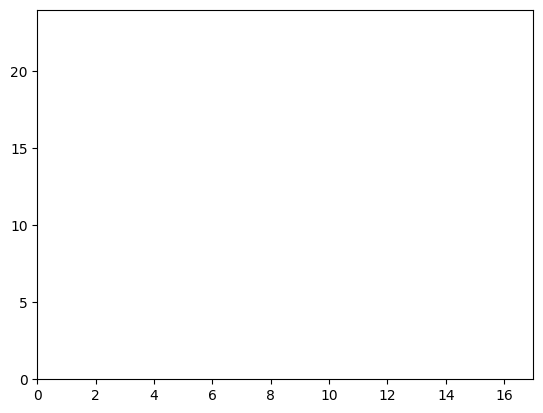

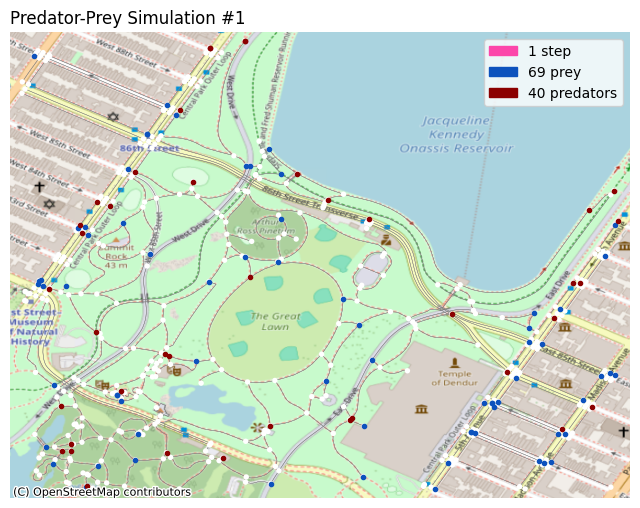

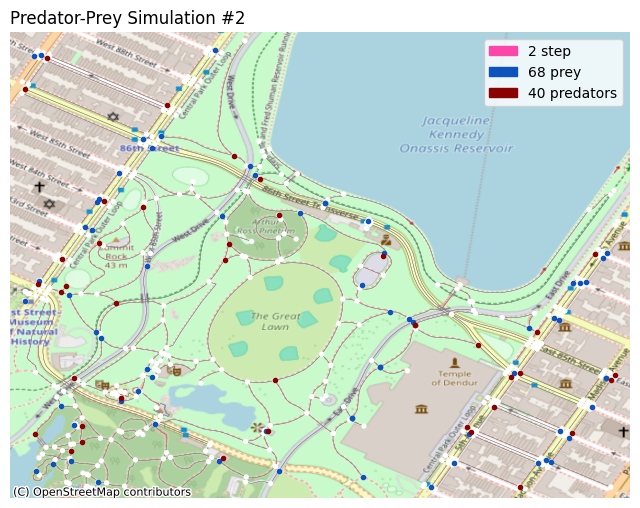

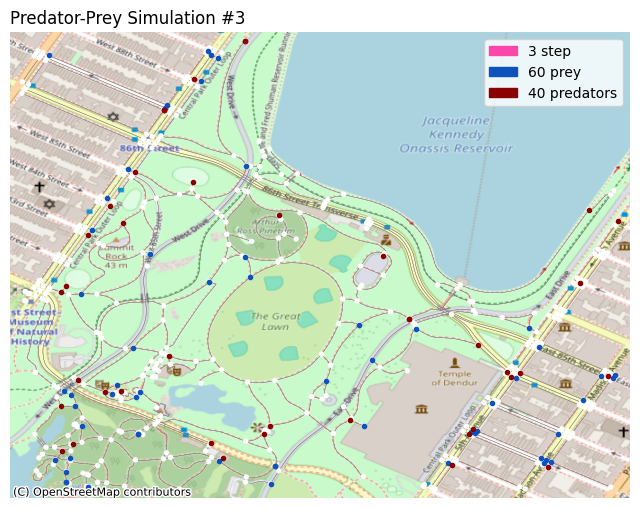

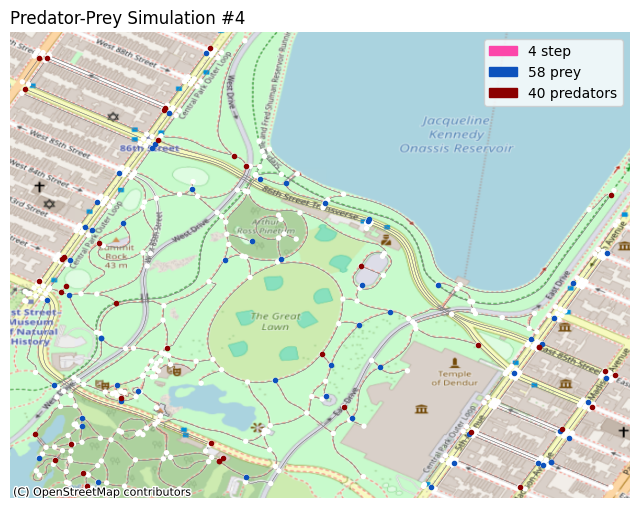

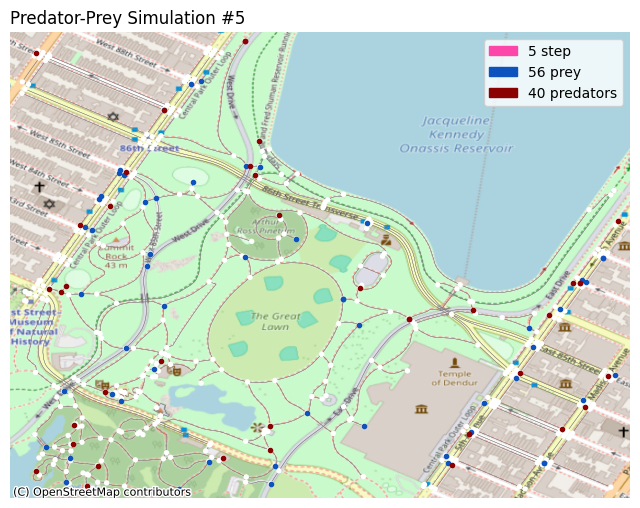

In [18]:
runner.init()

for episode in range(num_episodes):
  runner.step(num_steps_per_episode)
  
  final_states = list(filter(
    lambda x: x['current_substep'] == str(num_substeps_per_step - 1),
    runner.state_trajectory[-1]
  ))
  visualizer = Plot(metadata.get('max_x'), metadata.get('max_y'))
  visualizer.plot(final_states)

## Visualization

You can plot the simulation in different ways. In this notebook, two such methods are demonstrated; the X-Y grid, and the OpenStreetMap plot.

In [35]:
# display the gifs

from IPython.display import HTML

HTML("""
    <table>
    <tr><td>
    <video alt="grid" autoplay>
        <source src="../predator-prey.mp4" type="video/mp4">
    </video>
    </td><td>
    <img src="../predator-prey.gif" alt="map" />
    </td></tr>
    </table>
""")

,


In [17]:
# render the map

from IPython.display import display, clear_output

import time
import matplotlib
import matplotlib.pyplot as plotter
import matplotlib.patches as patcher
import contextily as ctx

%matplotlib inline

class Plot:
  def __init__(self, max_x, max_y):
    # intialize the scatterplot
    self.figure, self.axes = None, None
    self.prey_scatter, self.pred_scatter = None, None
    self.max_x, self.max_y = max_x, max_y

    plotter.xlim(0, max_x - 1)
    plotter.ylim(0, max_y - 1)
    self.i = 0

  def update(self, state):
    graph = state['network']['agent_agent']['predator_prey']['graph']
    self.coords = [(node[1]['x'], node[1]['y']) for node in graph.nodes(data=True)]
    self.coords.sort(key=lambda x: -(x[0] + x[1]))

    self.figure, self.axes = ox.plot_graph(graph, edge_linewidth=0.3, edge_color='gray', show=False, close=False)
    ctx.add_basemap(self.axes, crs=graph.graph['crs'], source=ctx.providers.OpenStreetMap.Mapnik)
    self.axes.set_axis_off()

    # get coordinates of all the entities to show.
    prey = state['agents']['prey']
    pred = state['agents']['predator']
    grass = state['objects']['grass']

    # agar energy > 0 hai... toh zinda ho tum!
    alive_prey = prey['coordinates'][torch.where(prey['energy'] > 0)[0]]
    alive_pred = pred['coordinates'][torch.where(pred['energy'] > 0)[0]]
    # show only fully grown grass, which can be eaten.
    grown_grass = grass['coordinates'][torch.where(grass['growth_stage'] == 1)[0]]

    alive_prey_x, alive_prey_y = np.array([
      self.coords[(self.max_y * pos[0]) + pos[1]] for pos in alive_prey
    ]).T
    alive_pred_x, alive_pred_y = np.array([
      self.coords[(self.max_y * pos[0]) + pos[1]] for pos in alive_pred
    ]).T

    # show prey in dark blue and predators in maroon.
    self.axes.scatter(alive_prey_x, alive_prey_y, c='#0d52bd', marker='.')
    self.axes.scatter(alive_pred_x, alive_pred_y, c='#8b0000', marker='.')

    # increment the step count.
    self.i += 1
    # show the current step count, and the population counts.
    self.axes.set_title('Predator-Prey Simulation #' + str(self.i), loc='left')
    self.axes.legend(handles=[
      patcher.Patch(color='#fc46aa', label=str(self.i) + ' step'),
      patcher.Patch(color='#0d52bd', label=str(len(alive_prey)) + ' prey'),
      patcher.Patch(color='#8b0000', label=str(len(alive_pred)) + ' predators'),
      # patcher.Patch(color='#d1ffbd', label=str(len(grown_grass)) + ' grass')
    ])
    
    display(plotter.gcf())
    clear_output(wait=True)
    time.sleep(1)

  def plot(self, states):
    # plot each state, one-by-one
    for state in states:
      self.update(state)

    clear_output(wait=True)